<a href="https://colab.research.google.com/github/amanjaiswal73892/changemypet/blob/master/MSE_average_losses_gif_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True).eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [3]:
model2 = torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True).eval()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!git clone "https://github.com/amanjaiswal73892/changemypet.git"

Cloning into 'changemypet'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 9), reused 27 (delta 1), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [17]:
# sample execution (requires torchvision)
from PIL import Image, ImageOps
from torchvision import transforms

input_image = Image.open('/content/dog_translate.png')
preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    model2.to('cuda')
# ouput_original_image = output.argmax(0).float()

In [5]:
from changemypet.src.biggan import BigGAN512
import torch 
import torchvision
from scipy.stats import truncnorm
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [19]:
truncation = torch.clamp(torch.tensor(0.4), min=0.02+1e-4, max=1.0-1e-4).float()  # truncation is 0.4
c = torch.tensor((268,)).long()  # class_label is 260
z = truncation * torch.as_tensor(truncnorm.rvs(-2.0, 2.0, size=(1, 128),random_state=20)).float()

z.requires_grad = True

biggan = BigGAN512()

biggan.load_state_dict(torch.load("/content/drive/My Drive/biggan/biggan512-release.pt"))

<All keys matched successfully>

In [ ]:
def softXEnt (input, target ):
    logprobs = torch.nn.functional.log_softmax (input, dim = 0)
    return  -(target * logprobs).sum() / (input.shape[1]*input.shape[2])

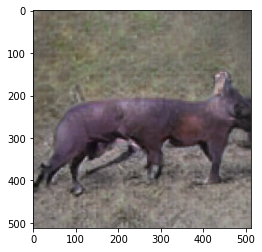

In [20]:
biggan.eval()

img = biggan(z, c, truncation.item())
pil = torchvision.transforms.ToPILImage()((0.5 * (img.data + 1)).squeeze())
# pil = torchvision.transforms.ToPILImage()((img).squeeze())
import PIL
# pil=ImageOps.mirror(pil)
# pil=pil.transpose(PIL.Image.ROTATE_90)
plt.imshow(pil)
# pil.save("dog_translate.png")

In [7]:
# required for creating gifs
def get_concat_h(im1, im2):
    dst_h = Image.new('RGB', (im1.width + im2.width, max(im1.height,im2.height)))
    dst_h.paste(im1, (0, 0))
    dst_h.paste(im2, (im1.width, 0))
    return dst_h

def get_concat_v(im1, im2):
    dst_v = Image.new('RGB', (max(im1.width,im2.width), im1.height + im2.height))
    dst_v.paste(im1, (0, 0))
    dst_v.paste(im2, (0, im1.height))
    return dst_v



In [8]:

output_original_image_1 = model(input_batch)['out'][0]
output_original_image_2 = model2(input_batch)['out'][0]
#applying softmax on original imgs segmaps
output_original_image_1_s=torch.nn.functional.softmax (output_original_image_1, dim = 0) #softmax o_o_1
output_original_image_2_s=torch.nn.functional.softmax (output_original_image_2, dim = 0) #softmax o_o_2
 #take average of 2 original img segmaps
output_o = (output_original_image_1_s + output_original_image_2_s)/2 # softmax_original_output_average


Epoch :  1
Loss  :  0.17506396770477295


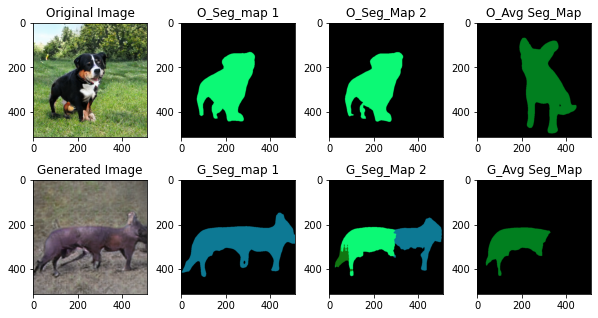

----------------------------------------------------------------------------------------------------
Epoch :  2
Loss  :  0.1566333770751953


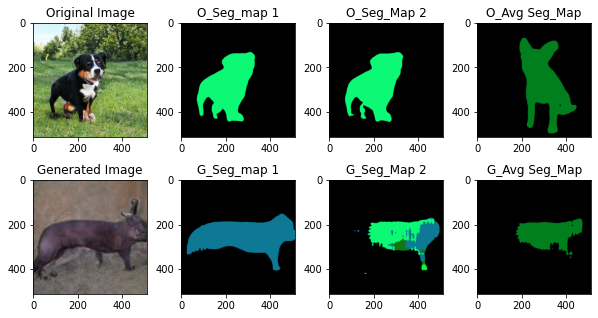

----------------------------------------------------------------------------------------------------
Epoch :  3
Loss  :  0.14083856344223022


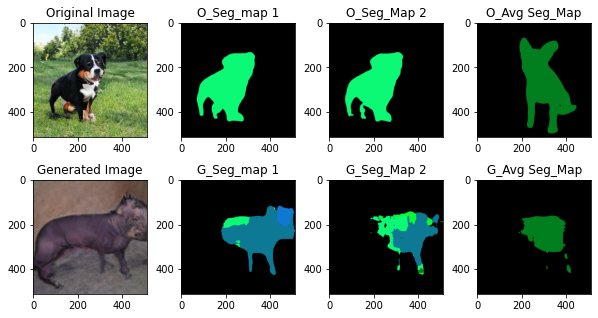

----------------------------------------------------------------------------------------------------
Epoch :  4
Loss  :  0.1393643319606781


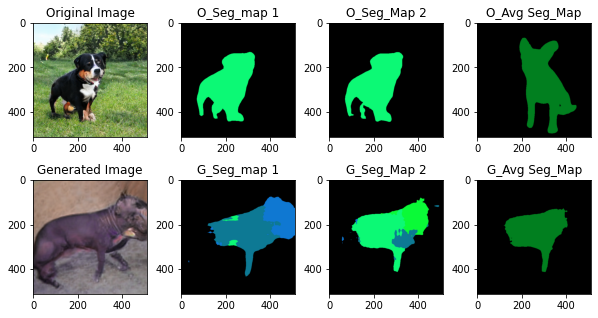

----------------------------------------------------------------------------------------------------
Epoch :  5
Loss  :  0.14743675291538239


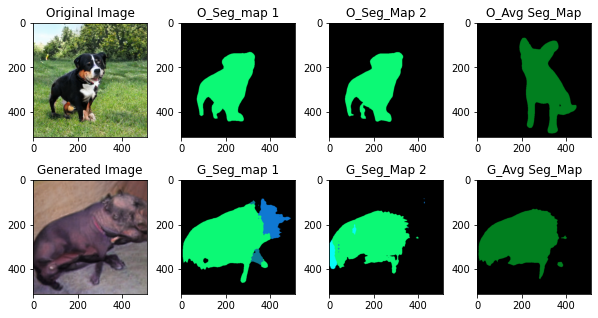

----------------------------------------------------------------------------------------------------


In [ ]:
gif = []
biggan.eval()
optimizer = torch.optim.Adam([z], lr=1e-1, betas=(0.5, 0.999))

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

for i in range(20):
    with torch.enable_grad():
        optimizer.zero_grad()
        img = biggan(z, c, truncation.item())
        
        #Segmentation of Predicted Img
        output_predicted_image_1 = model(0.5 * (img.cuda() + 1))['out'][0]
        output_predicted_image_2 = model2(0.5 * (img.cuda() + 1))['out'][0]
        
        #applying softmax on predicted imgs segmaps
        output_predicted_image_1_s = torch.nn.functional.softmax (output_predicted_image_1, dim = 0) #softmax o_P1
        output_predicted_image_2_s = torch.nn.functional.softmax (output_predicted_image_2, dim = 0) #softmax o_P2
        
        #take average of 2 predicted img segmaps
        output_p = (output_predicted_image_1_s * 0.6) + (output_predicted_image_2_s * 0.4)  # softmax_predicted_output_average
        
        #Segmentation of Original Img
        # output_original_image_1 = model(input_batch)['out'][0]
        # output_original_image_2 = model2(input_batch)['out'][0]
        
        # #applying softmax on original imgs segmaps
        # output_original_image_1_s=torch.nn.functional.softmax (output_original_image_1, dim = 0) #softmax o_o_1
        # output_original_image_2_s=torch.nn.functional.softmax (output_original_image_2, dim = 0) #softmax o_o_2
        
        # #take average of 2 original img segmaps
        # output_o = (output_original_image_1_s + output_original_image_2_s)/2 # softmax_original_output_average

        # output_o = output_o[12]

        # Target image segmaps
        # target = torch.nn.functional.softmax (output_o[[0,12]], dim = 0) # softmax on the target 
        target = output_o[12]
        loss = torch.nn.MSELoss()
        cost_x = loss(output_p[12],target)

        print("Epoch : ",i+1)
        print("Loss  : ", cost_x.item())


    fig = plt.figure(figsize=(10,5))
    plt.subplots_adjust(left = 0.125,right = 0.9,top=0.9,bottom = 0.1,wspace = 0.3,hspace = 0.2)

    ax1 = fig.add_subplot(241)
    ax1.title.set_text('Original Image')
    plt.imshow(input_image)

    ax2 = fig.add_subplot(242)
    ax2.title.set_text('O_Seg_map 1')
    r = Image.fromarray(model(input_batch)['out'][0].argmax(0).float().byte().cpu().numpy())#.resize(input_image.size)
    r.putpalette(colors)
    plt.imshow(r)
     
    ax3 = fig.add_subplot(243)
    ax3.title.set_text('O_Seg_Map 2')
    r = Image.fromarray(model2(input_batch)['out'][0].argmax(0).float().byte().cpu().numpy())#.resize(input_image.size)
    r.putpalette(colors)
    plt.imshow(r)

    ax4 = fig.add_subplot(244)
    ax4.title.set_text('O_Avg Seg_Map')
    seg_map_o = Image.fromarray(output_o[[0,12]].argmax(0).float().byte().cpu().numpy())
    seg_map_o.putpalette(colors)
    plt.imshow(seg_map_o)

    

    ax5 = fig.add_subplot(245)
    ax5.title.set_text('Generated Image')
    pil_gen = torchvision.transforms.ToPILImage()((0.5 * (img.data + 1)).squeeze())
    plt.imshow(pil_gen)

    ax6 = fig.add_subplot(246)
    ax6.title.set_text('G_Seg_map 1')
    r = Image.fromarray(output_predicted_image_1.argmax(0).float().byte().cpu().numpy())
    r.putpalette(colors)
    plt.imshow(r)

    ax7 = fig.add_subplot(247)
    ax7.title.set_text('G_Seg_Map 2')
    r = Image.fromarray(output_predicted_image_2.argmax(0).float().byte().cpu().numpy())
    r.putpalette(colors)
    plt.imshow(r)

 
    ax8 = fig.add_subplot(248)
    ax8.title.set_text('G_Avg Seg_Map')
    seg_map_gen = Image.fromarray(output_p[[0,12]].argmax(0).float().byte().cpu().numpy())
    seg_map_gen.putpalette(colors)
    plt.imshow(seg_map_gen)
    hz_1 = get_concat_h(input_image,pil_gen)
    hz_2 = get_concat_h(seg_map_o,seg_map_gen)
    v = get_concat_v(hz_1,hz_2)
    gif.append(v)
    plt.show()

    print('-'*100)
    cost_x.backward(retain_graph= True)
    optimizer.step()

print('End')

In [10]:
gif[0].save('out1.gif', save_all=True, append_images=gif[1:],optimize=False, duration=150, loop=0)

In [11]:
gif_2 = []
for x in gif:
  im = x
  (width, height) = (im.width // 2, im.height // 2)
  im_resized = im.resize((width, height))
  gif_2.append(im_resized)
gif_2[0].save('out_resized_1.gif', save_all=True, append_images=gif_2,optimize=False, duration=250, loop=0)